# Variable Settings

In [210]:
# read in the .imzML file
imzml_path = r"C:\Users\lawashburn\Documents\MSI_test\test_data_from_Hua\small_dataset_pos_20230216\psc_cell_ctrl_3-05-2022_smallarea021623.imzML"
ibd_path = r"C:\Users\lawashburn\Documents\MSI_test\test_data_from_Hua\small_dataset_pos_20230216\psc_cell_ctrl_3-05-2022_smallarea021623.ibd"
optical_path = r"small_dataset_pos_20230216/20220304_PSC_slide1_ctrl_image1_smallarea021623.tif"
output_spectra_path = r"C:\Users\lawashburn\Documents/MSI_test/20230323_smallData/20230325/spectra_report_out"
output_image_path = r"C:\Users\lawashburn\Documents/MSI_test/20230323_smallData/20230325/spectra_figure_out"

output_background_img_path = r"C:\Users\lawashburn\Documents/MSI_test/20230323_smallData/20230325/background_image_out"
output_cell_img_path = r"C:\Users\lawashburn\Documents/MSI_test/20230323_smallData/20230325/cell_image_out"

min_cell_pixels = 10
max_cell_pixels = 100
selected_mz = 810.6052
mz_tolerance = 0.1
z_value = 1
intensity_thresh = 2000


# feature m/z
mz_list = [810.6052,632.6295,604.5808,760.5623,808.5812,788.5988,786.5904] #absolute m/z tolerance

background_mz_list = [444.1061,614.1936,613.181,615.1925,595.178,596.1608,565.1754]
selected_bkgd_mz = 580.4977
##requirements##
## imzML and ibd files must be located in the same folder

# installs

In [6]:
pip install --upgrade pip

  Using cached pip-23.0.1-py3-none-any.whl (2.1 MB)
  Attempting uninstall: pip
    Found existing installation: pip 22.2.2
    Uninstalling pip-22.2.2:
      Successfully uninstalled pip-22.2.2
Note: you may need to restart the kernel to use updated packages.


In [7]:
pip install pyimzml

Note: you may need to restart the kernel to use updated packages.


In [8]:
pip install opencv-python

In [225]:
pip install -U kaleido

  Using cached kaleido-0.2.1-py2.py3-none-win_amd64.whl (65.9 MB)
Note: you may need to restart the kernel to use updated packages.


In [166]:
conda install -c conda-forge umap-learn

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\lawashburn\Anaconda3

  added / updated specs:
    - umap-learn


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    pynndescent-0.5.8          |     pyh1a96a4e_0          47 KB  conda-forge
    umap-learn-0.5.3           |   py39hcbf5309_0         132 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         179 KB

The following NEW packages will be INSTALLED:

  pynndescent        conda-forge/noarch::pynndescent-0.5.8-pyh1a96a4e_0 None
  umap-learn         conda-forge/win-64::umap-learn-0.5.3-py39hcbf5309_0 None




umap-learn-0.5.3     | 132 KB    |            |   0% 
umap-learn-0.5.3     | 132 KB    | #2         |  12% 
umap-learn-0.5.3     | 132 KB    | ########## | 100% 
umap-learn-0.5.3     | 132 KB    | ######



==> WARNING: A newer version of conda exists. <==
  current version: 22.9.0
  latest version: 23.1.0

Please update conda by running

    $ conda update -n base -c defaults conda




# imports

In [211]:
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
from plotly.subplots import make_subplots
import pandas as pd
import cv2
import copy
import csv
from IPython.display import display
from skimage import feature
from skimage import measure
from skimage.io import imread
from scipy import ndimage
import kaleido

In [212]:
from pyimzml.ImzMLParser import ImzMLParser
from pyimzml.ImzMLParser import getionimage
from scipy import signal
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
from plotly.subplots import make_subplots
import pandas as pd
import cv2
import copy
import csv
from IPython.display import display
from skimage import feature
from skimage import measure
from skimage.io import imread
from pyimzml.ImzMLParser import ImzMLParser
from pyimzml.ImzMLParser import getionimage
from scipy import signal
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
import cv2
from scipy.optimize import dual_annealing
import os
import sys
from skimage.measure import regionprops
from skimage.filters import median, gaussian, threshold_local
from skimage.feature import peak_local_max
from skimage.segmentation import watershed, relabel_sequential
from skimage.morphology import disk, label
from scipy import ndimage
import xlsxwriter
from sklearn.cluster import KMeans, DBSCAN
import random
import scipy
import scipy.ndimage
from PIL import Image
from numpy import asarray
from scipy import stats as st
from scipy.ndimage import median_filter
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap import UMAP

# functions

In [213]:
# mean filter applied diagonally
def diag_filter(img):
    temp_img=copy.deepcopy(img)
    for i in range(1,img.shape[0]-1):
        temp_img[i][i]=(img[i-1][i-1]+img[i][i]+img[i+1][i+1])/3
    
    temp_img2=copy.deepcopy(temp_img)
    for m in range(temp_img.shape[0]-2,0,-1):
        temp_img2[m][temp_img.shape[0]-1-m]=(temp_img[m+1][temp_img.shape[0]-2-m]+temp_img[m][temp_img.shape[0]-1-m]+temp_img[m-1][temp_img.shape[0]-m])/3
    return temp_img2

In [214]:
def mean_filter(img):
    # apply mean filter with 3*3 kernal to smooth image, return as 2D numpy array
    img_f = img
    for i in range(2,img.shape[0]-2):
        for j in range(2,img.shape[1]-2):
            block = img[i-1:i+1+1,j-1:j+1+1]
            m = np.mean(block,dtype=np.float32)
            img_f[i][j] = int(m)
    return(img_f)

In [215]:
def plot_by_mz(f,mz_list):
    # given a imzml file read in by ImzMLParser and a list of m/z feature list
    # plot MS images at the specific m/z values
    # Only apply to <= 12 m/z values since will plot at most 2*6 images
    img_f_list = list()
    for mz in mz_list:
            img = getionimage(f, mz, tol=0.1, z=1,reduce_func=sum)
            img_f = mean_filter(img)
            img_name = str(mz)
            mpimg.imsave(img_name, img_f)
            img_f_list.append(img_f)
    fig = make_subplots(rows=2, cols=-(len(img_f_list)//-2),subplot_titles=mz_list)
    for i in range(len(img_f_list)):
        if i+1 <= -(len(img_f_list)//-2):
            fig.add_trace(px.imshow(img_f_list[i]).data[0],1,i+1)
        else:
            fig.add_trace(px.imshow(img_f_list[i]).data[0],2,(i+(len(img_f_list)//-2)+1))
    fig.show()
    return()

In [216]:
def find_cell (img,i):
    # find cell areas - pixel with intensity >= given i
    # intensities of non-cell pixels are set to 0, return as 2D numpy array
    img_cell = img
    img_cell[img_cell<i] = 0
    return(img_cell)

In [217]:
def union (l):
    # union (x,y) of cells identified from different m/z values
    # set cell=1 non-cell=0
    dim = l[0].shape
    union_cell = np.zeros((dim[0],dim[1]))
    non_zeros = list()
    for n in l:
        non_zeros.append(np.argwhere(n>0))
    ones = list()
    for i in non_zeros:
        for (x,y) in i:
            if((x,y) not in ones):
                ones.append((x,y))
    for x, y in ones:
        union_cell[x][y]=1
    return(union_cell)

In [218]:
def dfs(img_cell):
    # depth first search used to find (x,y) of each cell
    # return a list of (x,y) coordinates for each cell
    # first set cell=1 and non-cell=0
    grid = img_cell
    grid[grid != 0]=1
    seen = set()
    l_all = list()
    for r0, row in enumerate(grid):
        for c0, val in enumerate(row):
            l = list()
            if val and (r0, c0) not in seen:
                stack = [(r0, c0)]
                seen.add((r0, c0))
                l.append((r0,c0))
                while stack:
                    r, c = stack.pop()
                    for nr, nc in ((r-1, c), (r+1, c), (r, c-1), (r, c+1)):
                        if (0 <= nr < len(grid) and 0 <= nc < len(grid[0]) and grid[nr][nc] and (nr, nc) not in seen):
                            stack.append((nr, nc))
                            seen.add((nr, nc))
                            l.append((nr,nc))
            l_all.append(l)
    return list(filter(None, l_all))

In [219]:
def mzbin(mz,intensity,start,end,resolution):
    # mz is an array of m/z values of a mass spectrum at some pixel
    # intensity is an array of corresponding intensities
    # start and end are the lower and upper bound m/z
    # resolution defines res of mass binning
    # returns result_mz: if a bin has edges 0.1-0.2, returns its center 0.15
    # result_intensity: the average intensity of every value falls into that bin
    step=(end-start)/resolution
    i=start
    result_mz=[]
    result_intensity=[]
    while i<end:
        avg_intensity=0
        count=0
        for j in range(len(mz)):
            if mz[j]<i+step and mz[j]>=i:
                avg_intensity+=intensity[j]
                count+=1 
        if count==0:
            result_intensity.append(0)
        else:
            result_intensity.append(avg_intensity/count)
        #print(avg_intensity)
        result_mz.append((i+i+step)/2)
        i+=step
    return result_mz,result_intensity

# main code

In [220]:
#import MSI data
f = ImzMLParser(imzml_path) #ibd path required to parse
for mz in mz_list:
    img = getionimage(f, mz, tol=mz_tolerance, z=z_value,reduce_func=sum) # img stored as 2D numpy array
    fig = px.imshow(img,title='Step 1: Combined Ion Plot')
    fig_path = output_cell_img_path + "\\" + str(mz) + ".png"
    fig.write_image(fig_path) 
for mz in background_mz_list:
    img = getionimage(f, mz, tol=mz_tolerance, z=z_value,reduce_func=sum) # img stored as 2D numpy array
    fig = px.imshow(img,title='Step 1: Combined Ion Plot')
    fig_path = output_background_img_path + "\\" + str(mz) + ".png"
    fig.write_image(fig_path) 
img = getionimage(f, mz, tol=mz_tolerance, z=z_value,reduce_func=sum) # img stored as 2D numpy array
for value in mz_list:
    mz_img = getionimage(f, value, tol=mz_tolerance, z=z_value,reduce_func=sum) # img stored as 2D numpy array
    img = np.add(img,mz_img)
fig = px.imshow(img,title='Step 1: Combined Ion Plot')

C:\Users\lawashburn\Anaconda3\lib\site-packages\pyimzml\ontology\ontology.py:92: UserWarning:

Accession IMS:1000046 found with incorrect name "pixel size x". Updating name to "pixel size (x)".



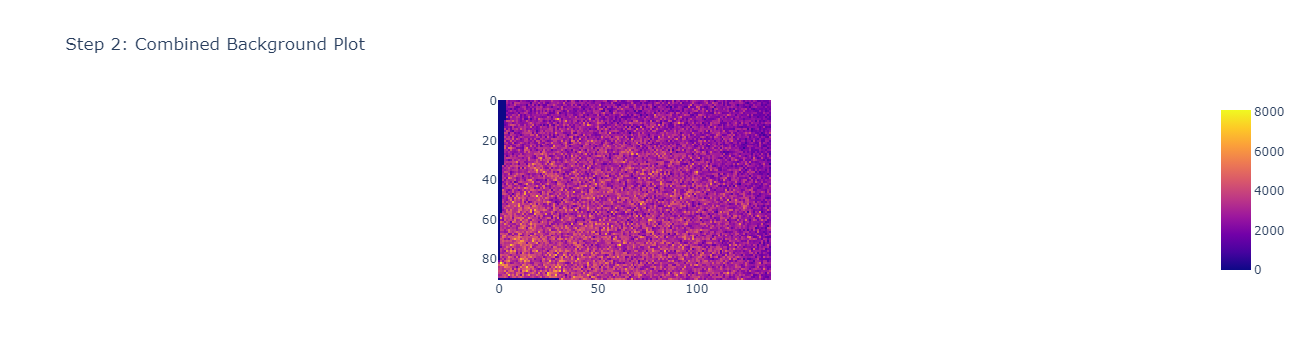

In [221]:
bkgd_img = getionimage(f, selected_bkgd_mz, tol=mz_tolerance, z=z_value,reduce_func=sum) # img stored as 2D numpy array
for value in background_mz_list:
    mz_img = getionimage(f, value, tol=mz_tolerance, z=z_value,reduce_func=sum) # img stored as 2D numpy array
    bkgd_img = np.add(bkgd_img,mz_img)
px.imshow(bkgd_img,title='Step 2: Combined Background Plot')

3051.3137442267875
988.9058867408392
12120.65889290288


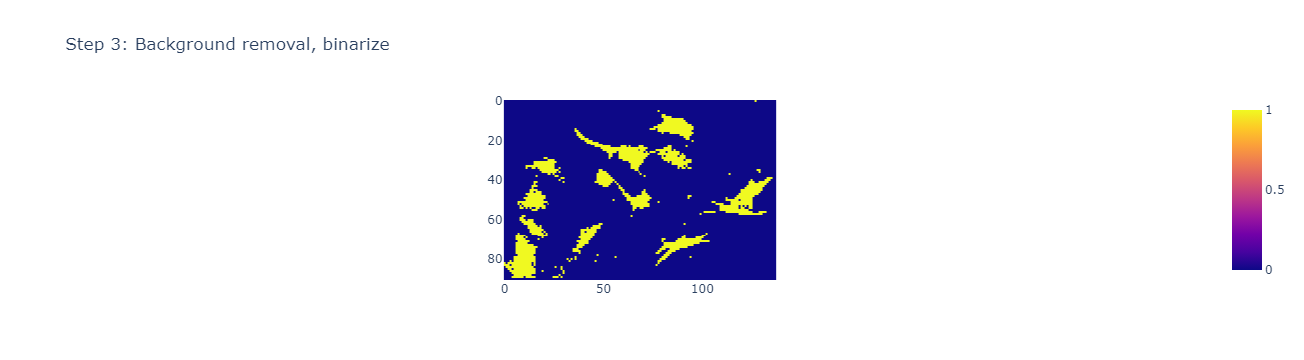

In [208]:
average_bkrd = np.average(bkgd_img)
print(average_bkrd)
std_bkrd = np.std(bkgd_img)
print(std_bkrd)
bkrd_intensity = (average_bkrd+std_bkrd)*3
print(bkrd_intensity)
img[img <= bkrd_intensity] = 0
img[img > 0] = 1
px.imshow(img,title='Step 3: Background removal, binarize')

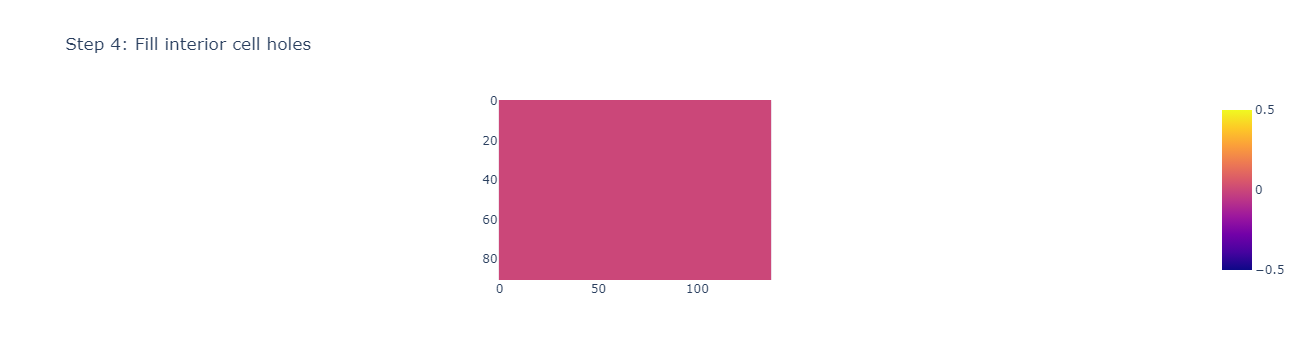

In [193]:
img = ndimage.binary_fill_holes(img).astype(int) #removes any holes in the interior of a cell
px.imshow(img,title='Step 4: Fill interior cell holes')

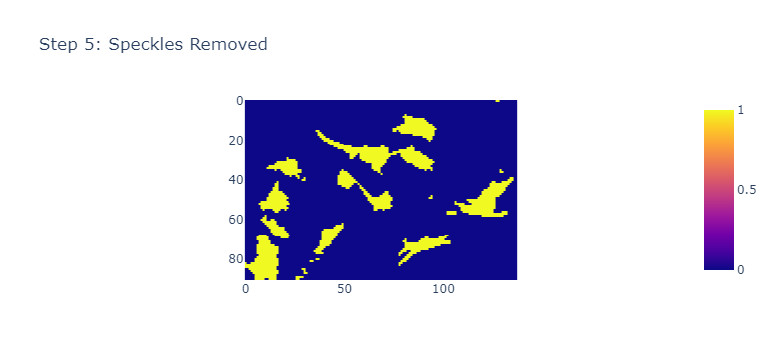

In [106]:
filtered_array = median_filter(img, size=2) #remove any "speckles" or regions of just one or two pixels
px.imshow(filtered_array,title="Step 5: Speckles Removed")

In [107]:
# determine if each pixel is a cell or not
img_cell = find_cell(filtered_array,1)

In [108]:
# split to each cell area
cc = dfs(img_cell)
len(cc) # num of total 'cells' identified

22

In [109]:
cell_localization_df = pd.DataFrame(columns=['x','y','cell_num'])
i = 1 # cell number
for l in cc:
    for x,y in l:
        cell_localization_df.loc[len(cell_localization_df.index)] = [y, x, i] 
    i = i+1

,x,y,cell_num,t
0,127,0,1,1
1,128,0,1,1
2,81,7,2,2
3,81,8,2,2
4,81,9,2,2
...,...,...,...,...
1677,26,90,22,22
1678,27,89,22,22
1679,27,90,22,22
1680,28,89,22,22


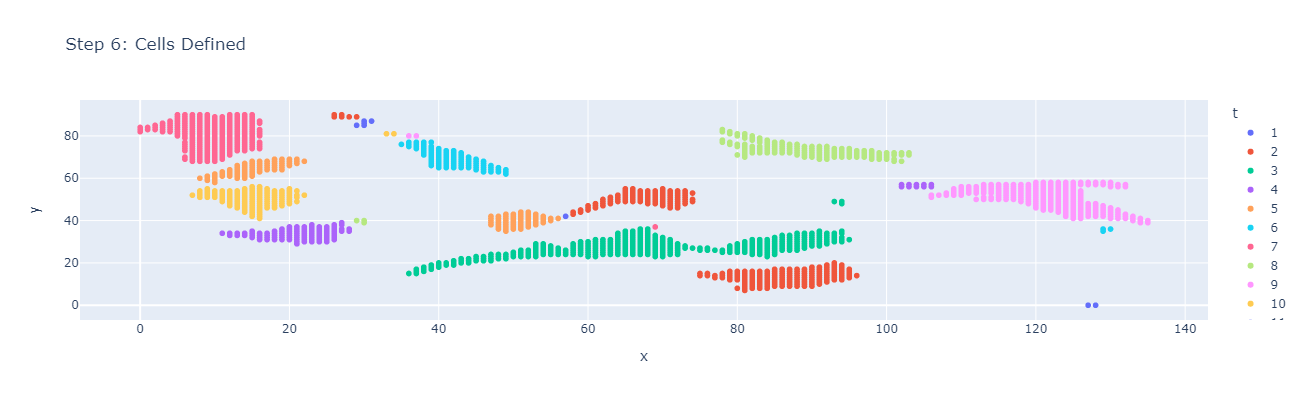

In [209]:
# visualize cells that have been found
cell_localization_df['t'] = cell_localization_df['cell_num'].astype('category')
display(cell_localization_df)
px.scatter(cell_localization_df, x='x',y='y',color='t',width=500,height=400,title="Step 6: Cells Defined")

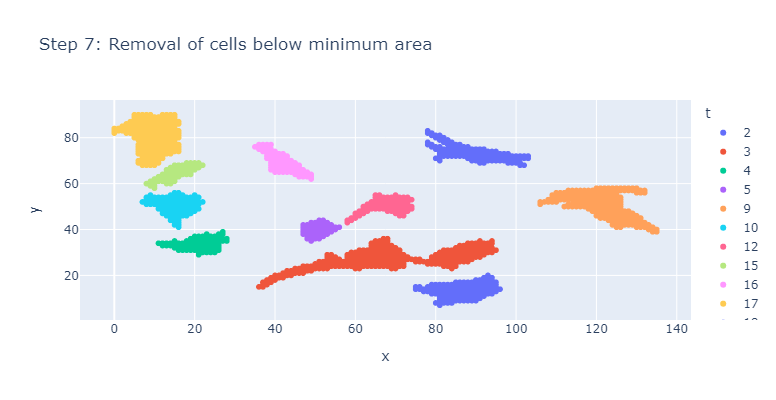

In [111]:
cell_numbers = cell_localization_df['cell_num'].values.tolist()
cell_number_no_dups = []
for aa in cell_numbers:
    if aa not in cell_number_no_dups:
        cell_number_no_dups.append(aa)

filtered_cells = pd.DataFrame()
min_cell_pixels = 50       
for bb in cell_number_no_dups:
    cell_local_filter = cell_localization_df[cell_localization_df['cell_num'] == bb]
    if len(cell_local_filter) >=min_cell_pixels:
        filtered_cells = pd.concat([filtered_cells,cell_local_filter])
    else:
        pass
filtered_cells['t'] = filtered_cells['cell_num'].astype('category')    
px.scatter(filtered_cells, x='x',y='y',color='t',width=500,height=400,title="Step 7: Removal of cells below minimum area")   

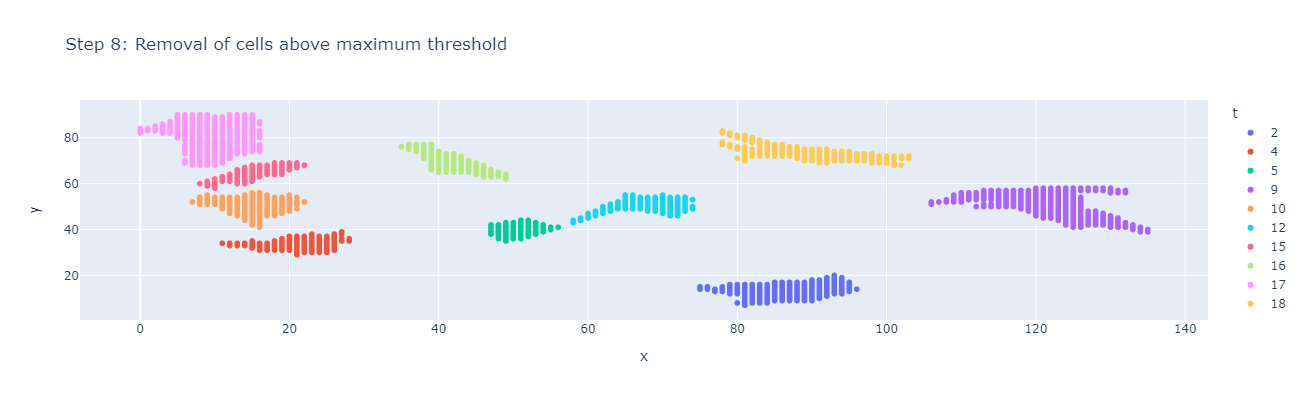

In [112]:
cell_numbers_post_filter = filtered_cells['cell_num'].values.tolist()
cell_numbers_post_filter_no_dups = []
for aa in cell_numbers_post_filter:
    if aa not in cell_numbers_post_filter_no_dups:
        cell_numbers_post_filter_no_dups.append(aa)

filtered_cells2 = pd.DataFrame()
max_cell_pixels =300        
for bb in cell_numbers_post_filter_no_dups:
    cell_local_filter2 = filtered_cells[filtered_cells['cell_num'] == bb]
    if len(cell_local_filter2) <=max_cell_pixels:
        filtered_cells2 = pd.concat([filtered_cells2,cell_local_filter2])
    else:
        pass
filtered_cells2['t'] = filtered_cells2['cell_num'].astype('category')    
px.scatter(filtered_cells2, x='x',y='y',color='t',width=500,height=400, title="Step 8: Removal of cells above maximum threshold")   

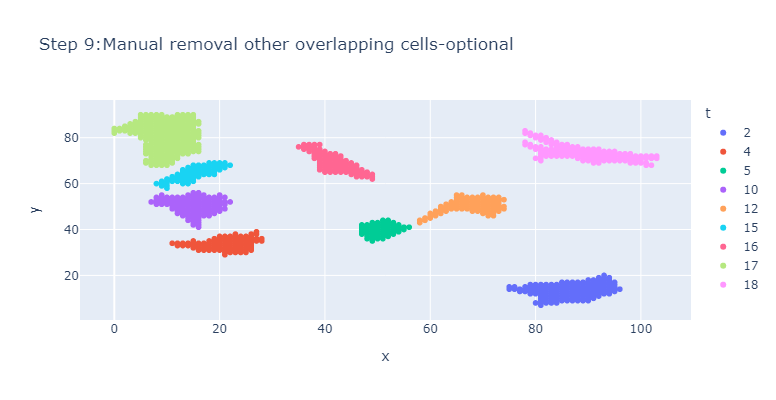

In [113]:
#manual removal of any cells

banned_cells = [9]

if len(banned_cells)>0:
    filtered_cells2 = filtered_cells2[~filtered_cells2['t'].isin(banned_cells)]
else:
    pass

filtered_cells2['t'] = filtered_cells2['cell_num'].astype('category')    
px.scatter(filtered_cells2, x='x',y='y',color='t',width=500,height=400, title="Step 9:Manual removal other overlapping cells-optional") 

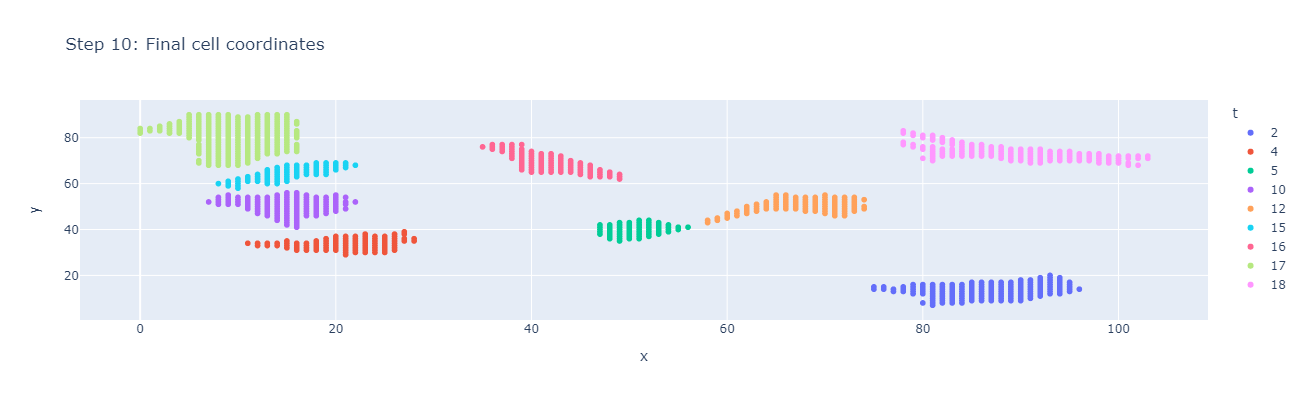

In [114]:
filtered_cells2["Identifier"] = filtered_cells2['x'].astype(str) +"_"+ filtered_cells2["y"].astype(str)

cell_IDs = filtered_cells2['Identifier'].values.tolist()

cell_ID_report = []
cell_ID_count = []

for cc in cell_IDs:
    cell_count = cell_IDs.count(cc)
    cell_ID_report.append(cc)
    cell_ID_count.append(cell_count)
    
cell_count_report = pd.DataFrame()
cell_count_report['ID'] = cell_ID_report
cell_count_report['Count'] = cell_ID_count

filtered_cells2['coordinate count'] = cell_ID_count
filtered_cells2 = filtered_cells2[filtered_cells2['coordinate count'] == 1]

filtered_cells2['t'] = filtered_cells2['cell_num'].astype('category')    
px.scatter(filtered_cells2, x='x',y='y',color='t',width=600,height=400,title="Step 10: Final cell coordinates")  

In [115]:
# dict - {x,y: index}
# a dictionary of pixel information
coord_dict = {}
for i in range(len(f.coordinates)):
    coord_dict[(f.coordinates[i][0],f.coordinates[i][1])]= i

In [119]:
final_cell_list_dups = filtered_cells2['t'].values.tolist()

final_cell_list = []
for l in final_cell_list_dups:
    if l not in final_cell_list:
        final_cell_list.append(l)
    else:
        pass
 

[2, 4, 5, 10, 12, 15, 16, 17, 18]

In [132]:
final_report = pd.DataFrame()
for m in final_cell_list:
    # the following is to extract the mean mass spectrum of the cell #1
    cell_one=filtered_cells2.loc[filtered_cells2['t'] == m]

    # do mass binning for each pixel in a cell, then calculate the average mass spectrum
    total_intensity=0
    output_intensity=[]
    output_mz=[]
    for i in range(len(cell_one)):
        try:
            xx=cell_one.iloc[i]['x']
            yy=cell_one.iloc[i]['y']
            index=coord_dict[(xx+1,yy+1)]
            mz, intensity = ImzMLParser.getspectrum(f,index) # retrieve mass spectrum at a pixel
            sum_intensity=sum(intensity)
            total_intensity+=sum_intensity
            result_mz,result_intensity=mzbin(mz, intensity, 50,600,7000)
            # print(result_mz,result_intensity)
            # print(sum_intensity)
            # calculate weighted average: sum(intensity of each cell * total intensity)/sum(total intensity)
            result_intensity=np.asarray(result_intensity)*sum_intensity 
            output_intensity.append(result_intensity)
            output_mz=result_mz
        except Exception:
            pass
    output=np.sum(output_intensity,axis=0)/total_intensity


    plt.plot(output_mz,output)
    plt.title("Cell #: "+str(m))
    file_name = output_image_path + "\\cell_number_" + str(m) + ".png" 
    plt.savefig(file_name)
    
    output_df = pd.DataFrame()
    output_df['m/z'] = output_mz
    output_df[("Cell #: " + str(m))] = output
    #output_df['cell_number'] = m
    if len(final_report)>0:
        final_report = final_report.merge(output_df,on='m/z',how='outer')
    else:
        final_report = pd.concat([final_report,output_df])
    
    plt.close()
file_path = output_spectra_path + '\\avg_spectra_all.csv'
with open(file_path,'w',newline='') as filec:
            writerc = csv.writer(filec)
            final_report.to_csv(filec,index=False)

In [272]:
final_report_transposed = final_report.transpose()
#final_report_transposed = final_report_transposed.iloc[1:, :]
final_report_transposed['CellType'] = "Panc1"
display(final_report_transposed)

,0,1,2,3,4,5,6,7,8,9,...,6992,6993,6994,6995,6996,6997,6998,6999,7000,CellType
m/z,50.039286,50.117857,50.196429,50.275,50.353571,50.432143,50.510714,50.589286,50.667857,50.746429,...,599.410714,599.489286,599.567857,599.646429,599.725000,599.803571,599.882143,599.960714,600.039286,Panc1
Cell #: 2,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,245.265136,295.186354,42.831649,4.416115,3.794015,5.450260,2.854522,5.864407,10.605722,Panc1
Cell #: 4,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,390.950579,277.221606,63.433257,4.907952,9.639564,2.769656,5.743513,7.458526,22.427041,Panc1
Cell #: 5,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,297.359474,230.047023,31.046132,0.939556,5.771555,0.751541,6.214990,6.456664,14.660847,Panc1
Cell #: 9,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,294.762629,245.472481,44.747295,6.212845,5.570278,4.279595,5.287239,3.737207,11.374159,Panc1
Cell #: 10,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,344.834212,331.460042,44.046642,7.652608,9.266347,4.355829,8.063263,7.645015,23.530620,Panc1
Cell #: 12,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,302.187006,222.389774,41.678144,2.268415,5.503064,3.562317,4.604202,4.233219,19.929211,Panc1
Cell #: 15,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,363.746331,272.249761,48.677558,4.069463,4.661062,6.035390,5.778843,9.892791,19.105110,Panc1
Cell #: 16,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,352.243182,291.212675,27.814595,6.056937,3.841552,4.952803,9.106688,7.500247,11.930038,Panc1
Cell #: 17,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,327.422632,382.849083,43.053131,5.316850,5.339635,3.869833,4.036092,11.093007,16.077996,Panc1


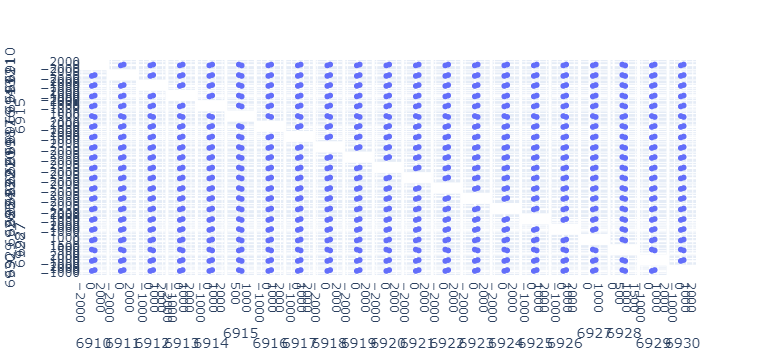

In [170]:
final_report_transposed2 = final_report_transposed.copy()

pca_columns = final_report_transposed2.loc[:, 6910:6930]

features = pca_columns #switch m/z features to columns 2-(-1)

fig = px.scatter_matrix(
    final_report_transposed2,
    dimensions=features
)
fig.update_traces(diagonal_visible=False)
fig.show()

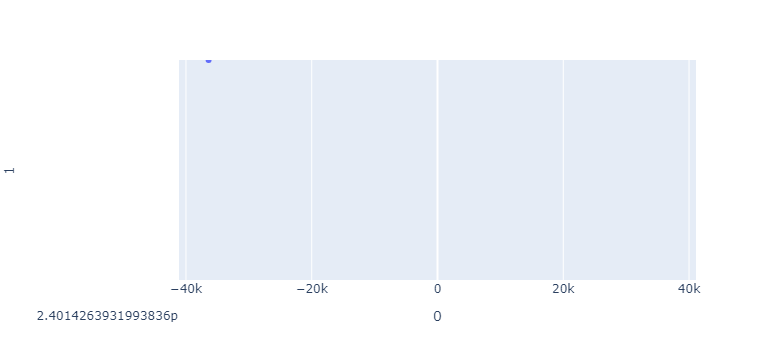

In [160]:

#X = final_report_transposed2.loc[:, 300:310]
X = final_report_transposed2.loc[:, 0:7000]
pca = PCA(n_components=2)
components = pca.fit_transform(X)

fig = px.scatter(components, x=0, y=1)
fig.show()

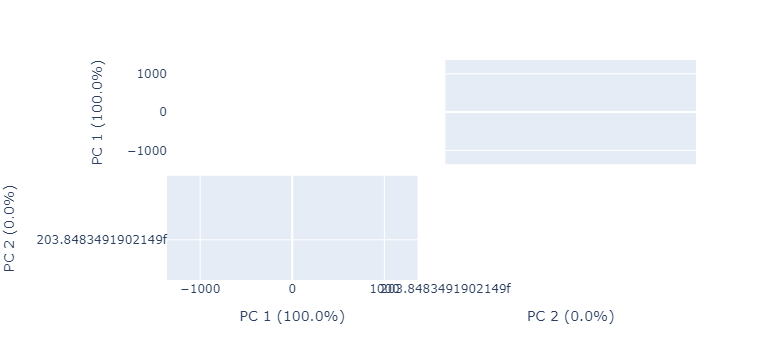

In [177]:
#df = px.data.iris()
#features = final_report_transposed2.loc[:, 6910:6930]

pca = PCA()
components = pca.fit_transform(final_report_transposed2.loc[:, 6910:6930])
labels = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
}

fig = px.scatter_matrix(
    components,
    labels=labels,
    dimensions=range(2)
)
fig.update_traces(diagonal_visible=False)
fig.show()

In [169]:
from umap import UMAP
import plotly.express as px

df = final_report_transposed2

features = df.loc[:, 6900:6910]

umap_2d = UMAP(n_components=2, init='random', random_state=0)
umap_3d = UMAP(n_components=3, init='random', random_state=0)

proj_2d = umap_2d.fit_transform(features)
proj_3d = umap_3d.fit_transform(features)

fig_2d = px.scatter(
    proj_2d, x=0, y=1,
    color=df.species, labels={'color': 'CellType'}
)
fig_3d = px.scatter_3d(
    proj_3d, x=0, y=1, z=2,
    color=df.species, labels={'color': 'CellType'}
)
fig_3d.update_traces(marker_size=5)

fig_2d.show()
fig_3d.show()

C:\Users\lawashburn\Anaconda3\lib\site-packages\umap\umap_.py:2344: UserWarning:

n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1

C:\Users\lawashburn\Anaconda3\lib\site-packages\umap\umap_.py:132: UserWarning:

A large number of your vertices were disconnected from the manifold.
Disconnection_distance = inf has removed 0 edges.
It has fully disconnected 2 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.



ValueError: zero-size array to reduction operation maximum which has no identity